In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from alibi_detect.cd import MMDDriftOnline

# ============================================================
# 設定（ここだけ変えればOK）
# ============================================================
NORMAL_CSV  = r"..\sampleData\csv_TEPdata\tuning-data.csv"
ANOMALY_CSV = r"..\sampleData\csv_TEPdata\idv_str14_data.csv"   # 例: idv_str1_data.csv などに切替

TIME_COL  = None   # "None" ではなく None
LABEL_COL = None

FEATURE_COLS = None          # Noneなら数値列から自動
SENSOR_COLS  = None          # Noneなら FEATURE_COLS を使う（例: ["s1","s2"] に固定も可）

# ---- PCA（次元削減） ----
USE_PCA = True
PCA_N_COMPONENTS = 20        # 例: 10, 20, 30（元の次元以下にする）
PCA_WHITEN = False           # 基本 False（True はスケールを揃えたいとき）

# ============================================================
# 0) 入力
# ============================================================
df_normal = pd.read_csv(NORMAL_CSV)
df_anom   = pd.read_csv(ANOMALY_CSV)

# ============================================================
# 1) 特徴量列
# ============================================================
if FEATURE_COLS is None:
    cols = df_normal.select_dtypes(include=[np.number]).columns.tolist()
    if TIME_COL is not None and TIME_COL in cols: cols.remove(TIME_COL)
    if LABEL_COL is not None and LABEL_COL in cols: cols.remove(LABEL_COL)
    FEATURE_COLS = cols

if SENSOR_COLS is None:
    SENSOR_COLS = FEATURE_COLS

missing = [c for c in SENSOR_COLS if c not in df_anom.columns]
if missing:
    raise ValueError(f"ANOMALY_CSV に列がありません: {missing}")

X_ref_all = df_normal[SENSOR_COLS].to_numpy(np.float32)
X_test    = df_anom[SENSOR_COLS].to_numpy(np.float32)

# ============================================================
# 2) 参照を範囲で切り出し → 標準化（参照でfit）
# ============================================================
X_ref   = X_ref_all

scaler     = StandardScaler()
X_ref_std  = scaler.fit_transform(X_ref).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

print(f"参照データ（標準化後）: {X_ref_std.shape}, テストデータ（標準化後）: {X_test_std.shape}")

# ============================================================
# 2.5) PCA（参照でfit）→ 低次元へ変換
# ============================================================
if USE_PCA:
    n_comp = int(min(PCA_N_COMPONENTS, X_ref_std.shape[1]))
    if n_comp < 1:
        raise ValueError("PCA_N_COMPONENTS は 1 以上にしてください。")

    pca = PCA(n_components=n_comp, whiten=PCA_WHITEN)
    X_ref_pca  = pca.fit_transform(X_ref_std).astype(np.float32)
    X_test_pca = pca.transform(X_test_std).astype(np.float32)

    cum = np.cumsum(pca.explained_variance_ratio_)
    print(f"PCA 次元: {X_ref_pca.shape[1]} / 元: {X_ref_std.shape[1]}")
    print(f"PCA 累積寄与率（最後）: {float(cum[-1]):.4f}")
else:
    # PCAを使わない場合は、そのまま標準化データを使う
    X_ref_pca  = X_ref_std
    X_test_pca = X_test_std


参照データ（標準化後）: (960, 52), テストデータ（標準化後）: (960, 52)
PCA 次元: 20 / 元: 52
PCA 累積寄与率（最後）: 0.7241


In [4]:
# ============================================================
# 3) Online MMD の初期化（閾値の校正を含む）
# ============================================================
window_size  = 20
ert          = 100.0
n_bootstraps = 2000
backend      = "tensorflow"  # "pytorch" でも可

# ---- 重要：参照データの長さチェック ----
# Online MMD は、参照データから window_size の窓を作ってブートストラップします。
# 少なくとも (window_size + ceil(ert) - 1) 点は欲しいです。
n_ref = X_ref_pca.shape[0]
need = int(window_size + np.ceil(ert) - 1)
if n_ref < need:
    raise ValueError(
        f"参照データが短すぎます: n_ref={n_ref}, window_size={window_size}, ert={ert} -> 必要目安 >= {need}。"
        "（対処：参照を長くする / window_sizeを小さくする / ertを小さくする）"
    )

cd = MMDDriftOnline(
    x_ref=X_ref_pca,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


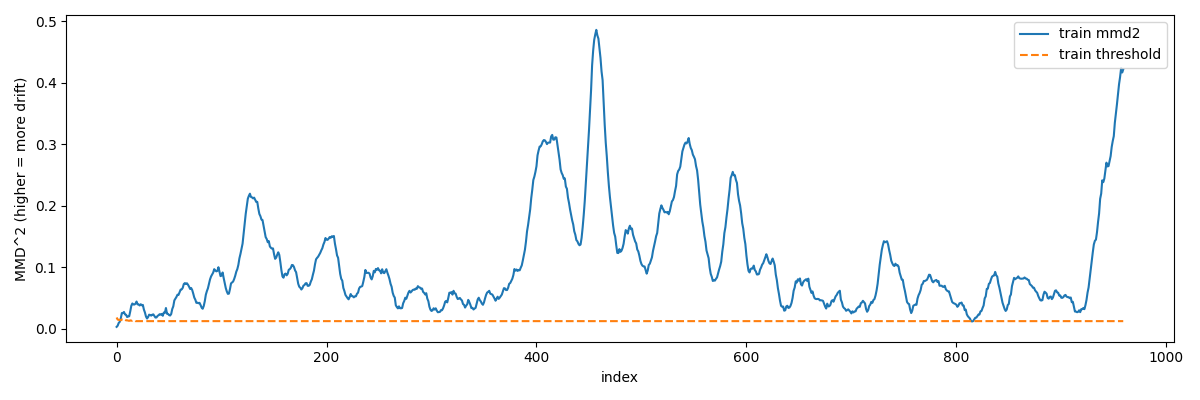

In [5]:
%matplotlib widget

# ============================================================
# 4) 正常(df_normal) を流してスコア算出＋可視化
#    ※ cd は状態（窓）を持つので、流すデータは cd と同じスケール（ここでは PCA後）に合わせる
# ============================================================

FIGSIZE = (12, 4)
YLIM    = None  # 例: (0, 5.0)

n_tr = X_ref_pca.shape[0]
mmd2_tr = np.full(n_tr, np.nan, float)
thr_tr  = np.full(n_tr, np.nan, float)
dr_tr   = np.zeros(n_tr, int)

for i in range(n_tr):
    out = cd.predict(X_ref_pca[i], return_test_stat=True)
    d = out["data"]
    mmd2_tr[i] = float(d.get("test_stat", np.nan))
    thr_tr[i]  = float(d.get("threshold", np.nan))
    dr_tr[i]   = int(d.get("is_drift", 0))

t_tr = df_normal[TIME_COL].to_numpy() if (TIME_COL and TIME_COL in df_normal.columns) else np.arange(n_tr)

df_log_train = pd.DataFrame({
    "i": np.arange(n_tr),
    "t": t_tr,
    "mmd2": mmd2_tr,
    "threshold": thr_tr,
    "is_drift": dr_tr
})

plt.figure(figsize=FIGSIZE)
plt.plot(df_log_train["t"], df_log_train["mmd2"], label="train mmd2")
plt.plot(df_log_train["t"], df_log_train["threshold"], "--", label="train threshold")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_normal.columns) else "index")
plt.ylabel("MMD^2 (higher = more drift)")
if YLIM is not None: plt.ylim(*YLIM)
plt.legend(); plt.tight_layout(); plt.show()


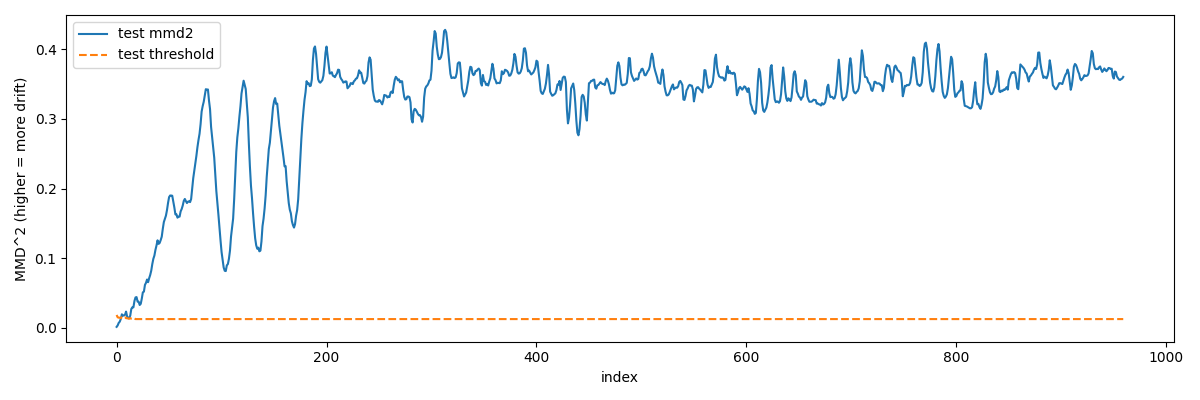

In [6]:
# ============================================================
# 5) train の後に test を流すなら必須（状態を初期化）
# ============================================================
cd.reset_state()

# ============================================================
# 6) テスト(df_anom) を流してスコア算出＋可視化
# ============================================================

n_te = X_test_pca.shape[0]
mmd2_te = np.full(n_te, np.nan, float)
thr_te  = np.full(n_te, np.nan, float)
dr_te   = np.zeros(n_te, int)

for i in range(n_te):
    out = cd.predict(X_test_pca[i], return_test_stat=True)
    d = out["data"]
    mmd2_te[i] = float(d.get("test_stat", np.nan))
    thr_te[i]  = float(d.get("threshold", np.nan))
    dr_te[i]   = int(d.get("is_drift", 0))

t_te = df_anom[TIME_COL].to_numpy() if (TIME_COL and TIME_COL in df_anom.columns) else np.arange(n_te)

df_log_test = pd.DataFrame({
    "i": np.arange(n_te),
    "t": t_te,
    "mmd2": mmd2_te,
    "threshold": thr_te,
    "is_drift": dr_te
})

plt.figure(figsize=FIGSIZE)
plt.plot(df_log_test["t"], df_log_test["mmd2"], label="test mmd2")
plt.plot(df_log_test["t"], df_log_test["threshold"], "--", label="test threshold")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_anom.columns) else "index")
plt.ylabel("MMD^2 (higher = more drift)")
if YLIM is not None: plt.ylim(*YLIM)
plt.legend(); plt.tight_layout(); plt.show()
